#Imports & functions

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm,t

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def norm_ticket_dist(returns, ticket):
    fig, ax = plt.subplots(figsize=(10, 6))
    returns[ticket].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
    x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
    plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
    plt.title("{} returns vs. Normal distribution".format(ticket))
    plt.show()

In [ ]:
def student_ticket_dist(returns, ticket):
    fig, ax = plt.subplots(figsize=(10, 6))
    shape, loc, scale = t.fit(returns[ticket])
    returns[ticket].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
    x = np.linspace(returns[ticket].min(), returns[ticket].max(),100)
    plt.plot(x, t.pdf(x, shape, loc=loc, scale=scale), "r")
    plt.title("{} returns vs. Student distribution".format(ticket))
    plt.show()

In [ ]:
def n_day_var(num_days, var):
    var_array = []
    for x in range(1, num_days+1):
        var_array.append(np.round(var * np.sqrt(x),2))

    var_array = [x/initial_investment for x in var_array]
    plt.xlabel("Day №")
    plt.ylabel("Max portfolio loss, %")
    plt.title("Max portfolio loss (VaR) over {}-day period".format(num_days))
    plt.plot(var_array, "r")

In [ ]:
def breakdown_graph(returns, var_function, w = 200):
    i = w
    portf = returns.copy()
    var_values = pd.DataFrame({'Date': [], 'VaR': []})

    while i <=portf.shape[0]:
        var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i-1:i].index.date[0]], 'VaR': [-1*var_function(portf[i-w-1:i])]})])
        i+=1

    portf= portf[w:].dot(weights)
    var_values['Date'] = pd.to_datetime(var_values['Date'])
    var_df = var_values.merge(portf.reset_index(), on='Date')
    var_df.columns = ['Date', 'VaR', 'Change']
    var_df['Violation'] = (var_df['Change'] < var_df['VaR'])


    fig, ax = plt.subplots(figsize=(10, 6))
    pos = portf[portf.apply(lambda x: x >= 0)]
    neg = portf[portf.apply(lambda x: x <  0)]

    plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
    plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
    plt.scatter(var_df.Date, var_df.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
    plt.plot(var_df.Date, var_df.VaR, label = 'VaR', c = 'black')
    plt.legend()
    plt.title("{} VaR violations; window_size = {}".format(var_function.__name__.upper(), w))
    plt.show();

    return var_df

In [ ]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

def tests(df):
    print("%.2f" % pof_test(df['VaR'], df['Change']))
    print("%.2f" % if_test(df['VaR'], df['Change']))

# Data load & preparation

In [ ]:
url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/commodities_dataset.csv'
open('commodities_dataset.csv', 'wb').write(requests.get(url).content)
commodities = pd.read_csv('commodities_dataset.csv')#, index_col='Date'


url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/stocks_dataset.csv'
open('stocks_dataset.csv', 'wb').write(requests.get(url).content);
stocks = pd.read_csv('stocks_dataset.csv')#, index_col='Date'

In [ ]:
stocks['Date'] =  pd.to_datetime(stocks['Date'])
stocks['year'] = stocks['Date'].dt.year

stocks = stocks.set_index('Date')
stocks = stocks[stocks['year'] >= 2021]
stocks = stocks.drop(columns=['year'])

commodities['Date'] =  pd.to_datetime(commodities['Date'])
commodities['year'] = commodities['Date'].dt.year

commodities = commodities.set_index('Date')
commodities = commodities[commodities['year'] >= 2021]
commodities = commodities.drop(columns=['year'])

stocks.head()

,AMD,NFLX,CVX,EA,LMT,PFE,HCA,MT,WMT,NKE,V,JNJ,SE,GE,RYCEY
Date,,,,,,,,,,,,,,,
2021-01-04,92.300003,522.859985,84.709999,139.509995,344.640015,36.810001,163.639999,23.950001,146.529999,140.100006,217.759995,156.500000,196.059998,65.386414,1.50
2021-01-05,92.769997,520.799988,87.000000,141.320007,348.790009,37.189999,165.009995,24.620001,145.750000,141.229996,214.509995,158.339996,202.929993,67.259956,1.54
2021-01-06,90.330002,500.489990,89.800003,136.800003,348.029999,36.869999,170.559998,24.700001,146.660004,142.350006,212.619995,159.830002,194.369995,70.944572,1.55
2021-01-07,95.160004,508.890015,90.220001,140.740005,342.549988,37.060001,173.600006,25.520000,146.649994,144.949997,213.809998,160.369995,203.940002,70.382515,1.54
2021-01-08,94.580002,510.399994,91.080002,141.860001,336.100006,37.130001,172.279999,24.830000,146.630005,146.350006,215.449997,160.039993,210.160004,70.819672,1.52


In [ ]:
returns = stocks.pct_change()
com_returns = commodities.pct_change()

returns.tail()

,AMD,NFLX,CVX,EA,LMT,PFE,HCA,MT,WMT,NKE,V,JNJ,SE,GE,RYCEY
Date,,,,,,,,,,,,,,,
2023-06-06,0.053422,-0.010532,0.001801,0.000945,0.008665,-0.007245,-0.003820,0.009811,-0.000134,0.009411,0.006394,-0.000884,0.045734,0.013064,0.005556
2023-06-07,-0.051517,0.001202,0.025932,-0.007079,0.006803,0.013552,0.008629,0.002616,0.001469,0.008475,-0.012926,0.002150,-0.005059,0.005879,0.005525
2023-06-08,0.027328,0.024014,-0.003691,0.006892,0.005241,0.005143,-0.000146,0.020127,0.014467,-0.008311,-0.009855,0.010976,0.042152,-0.000094,0.005495
2023-06-09,0.031970,0.026016,-0.002386,-0.009205,-0.003189,-0.003070,-0.006216,-0.002558,0.006046,-0.003201,0.002286,-0.001560,-0.002518,0.002168,0.000000
2023-06-12,0.034182,0.009404,-0.009631,-0.001429,-0.006095,0.023865,0.016373,0.000733,0.006597,0.009163,0.011675,-0.000687,0.026033,-0.000659,0.005464


In [ ]:
VaR_values = {}
weights = np.array([1/15]*15)

# Base portfolio statistics

In [ ]:
conf_level = 0.01


initial_investment = 10000000
cov_matrix = returns.cov()

avg_rets = returns.mean()

port_mean = avg_rets.dot(weights)
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

mean_investment = (1+port_mean) * initial_investment
stdev_investment = initial_investment * port_stdev

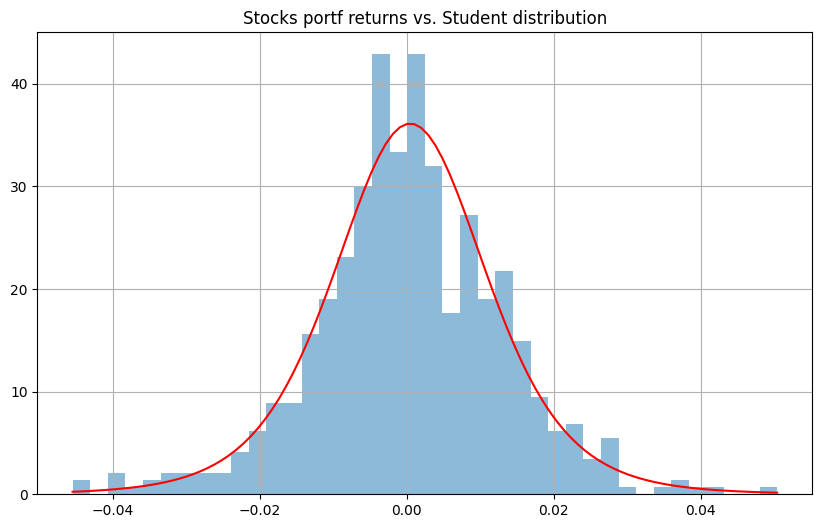

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
shape, loc, scale = t.fit(returns.dot(weights)[1:])
returns.dot(weights)[1:].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
#x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
x = np.linspace(returns.dot(weights)[1:].min(), returns.dot(weights)[1:].max(),100)
plt.plot(x, t.pdf(x, shape, loc=loc, scale=scale), "r")
plt.title("Stocks portf returns vs. Student distribution")
plt.show()

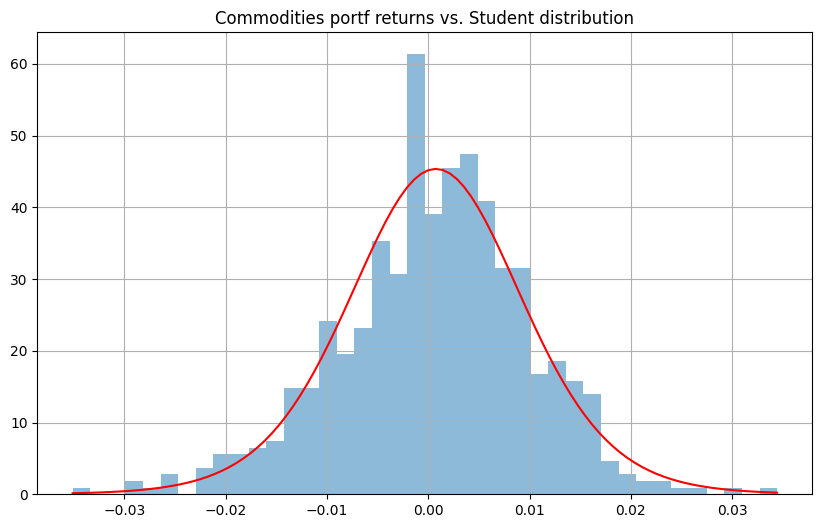

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
shape, loc, scale = t.fit(com_returns.dot(weights)[1:])
com_returns.dot(weights)[1:].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(com_returns.dot(weights)[1:].min(), com_returns.dot(weights)[1:].max(),100)
plt.plot(x, t.pdf(x, shape, loc=loc, scale=scale), "r")
plt.title("Commodities portf returns vs. Student distribution")
plt.show()

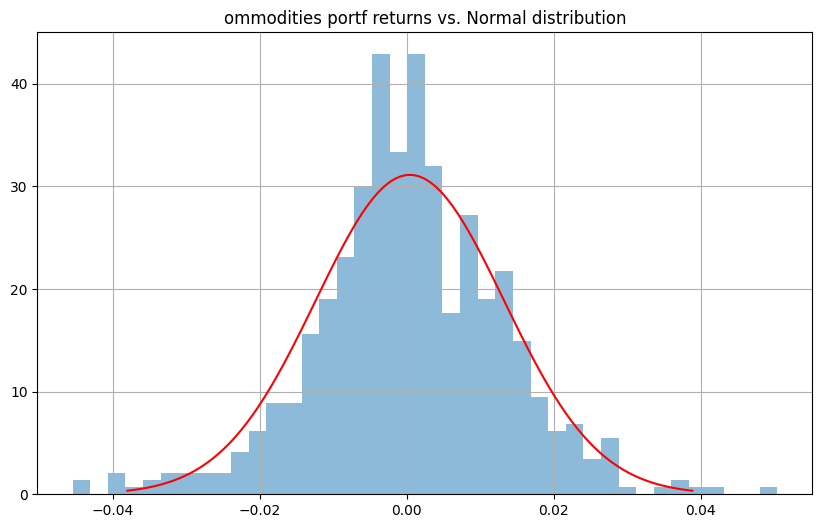

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
returns.dot(weights)[1:].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("ommodities portf returns vs. Normal distribution")
plt.show()

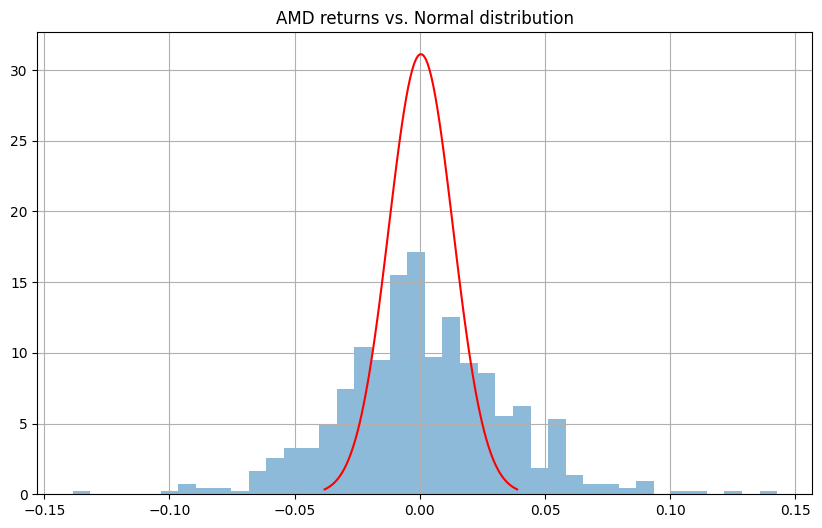

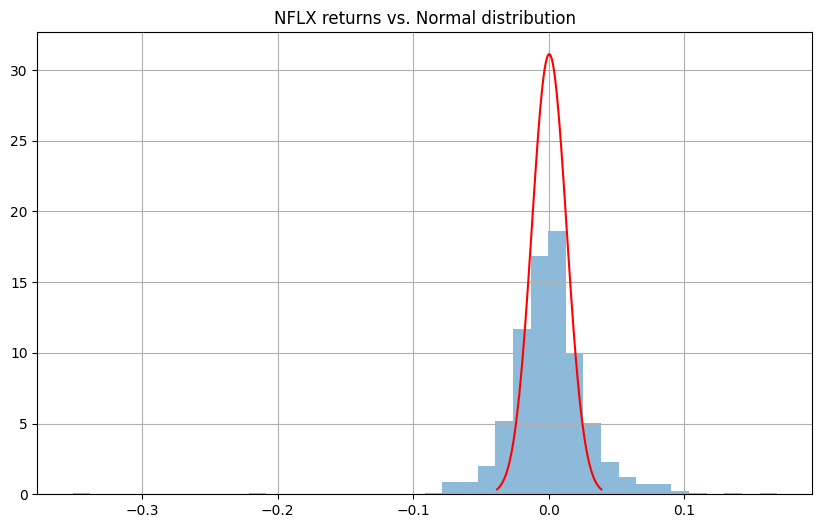

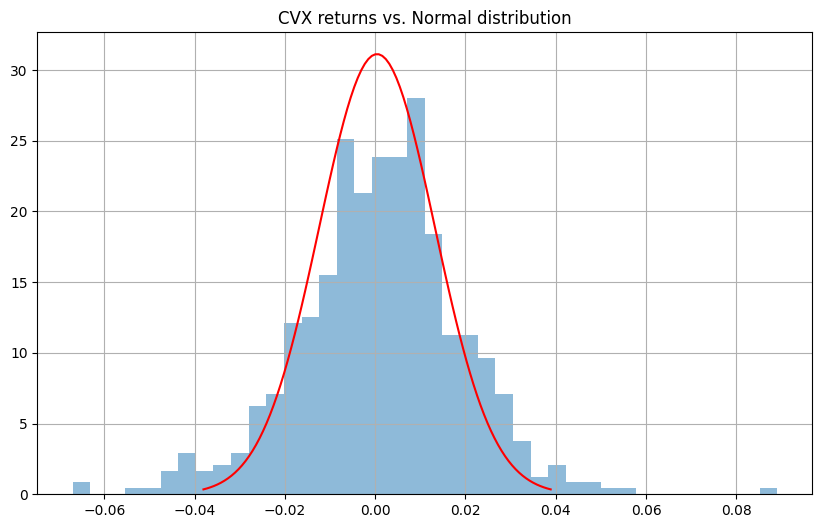

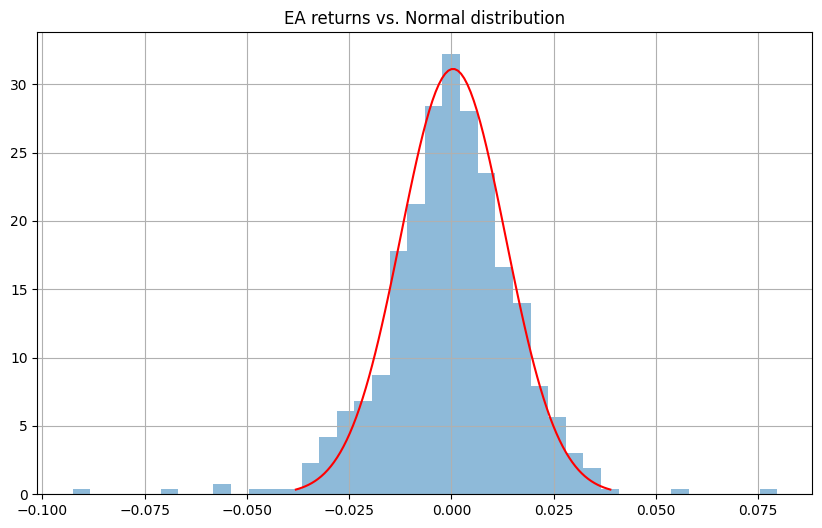

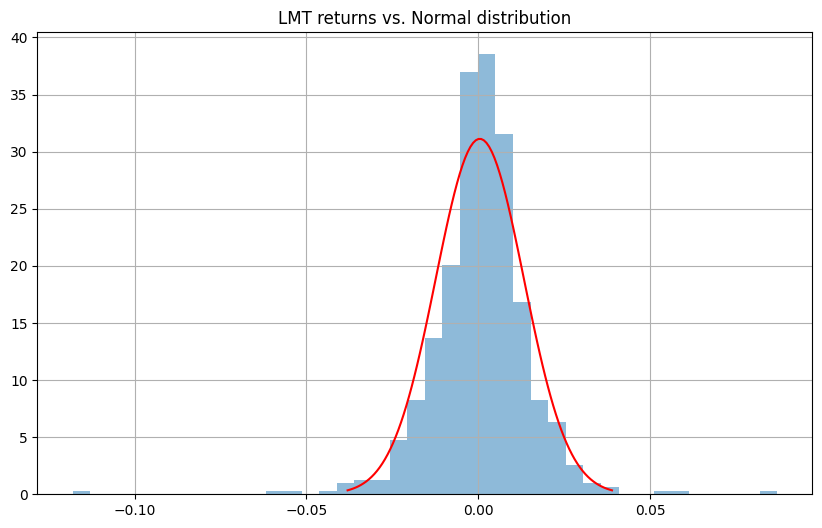

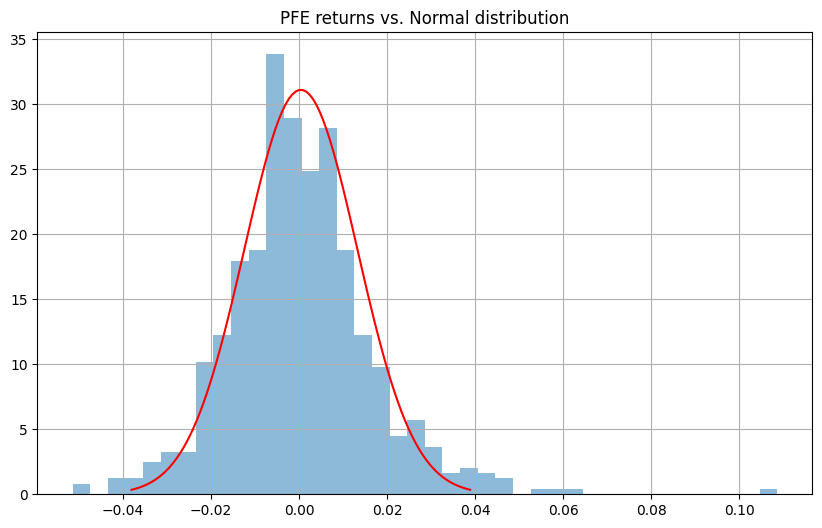

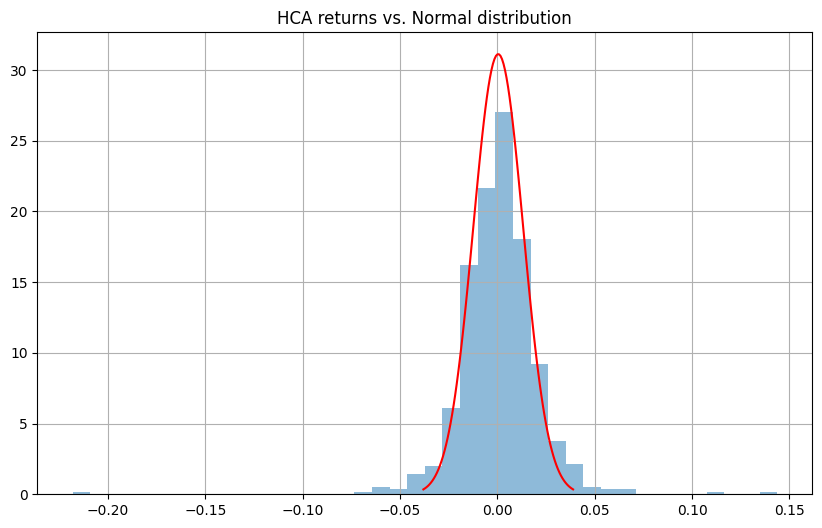

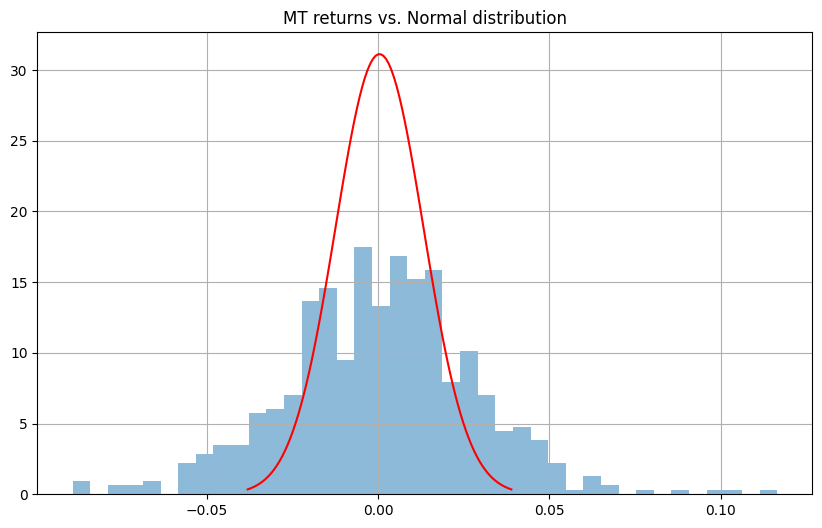

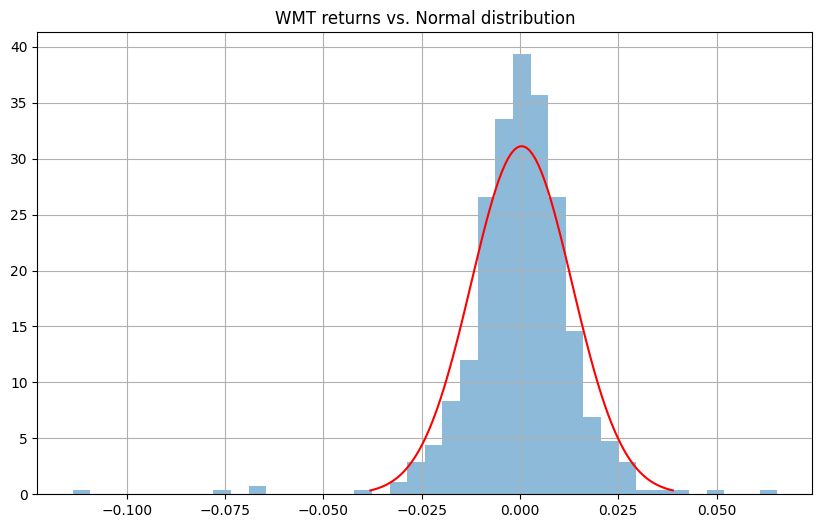

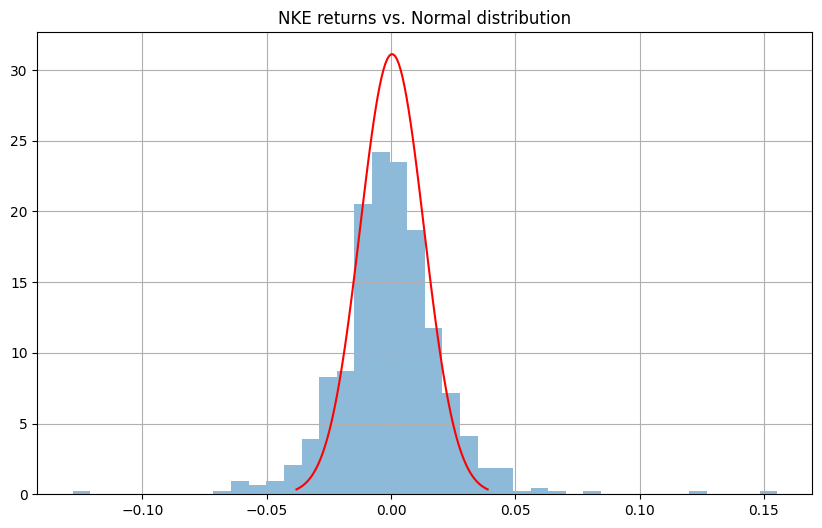

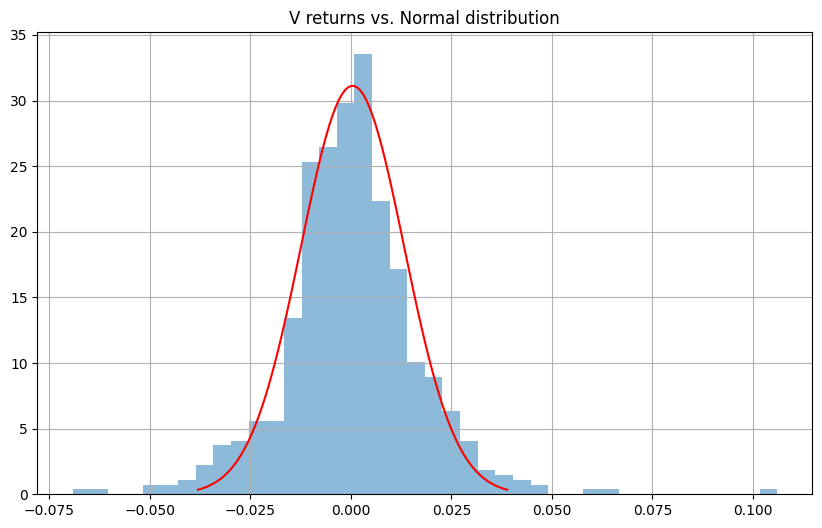

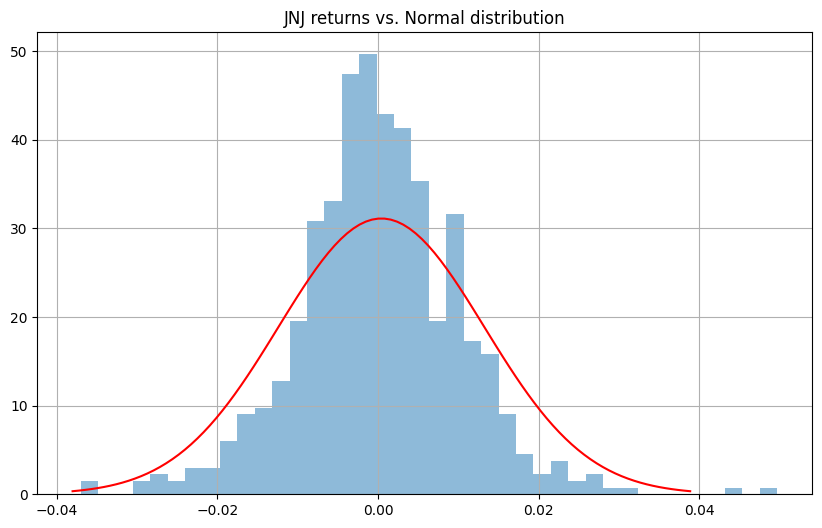

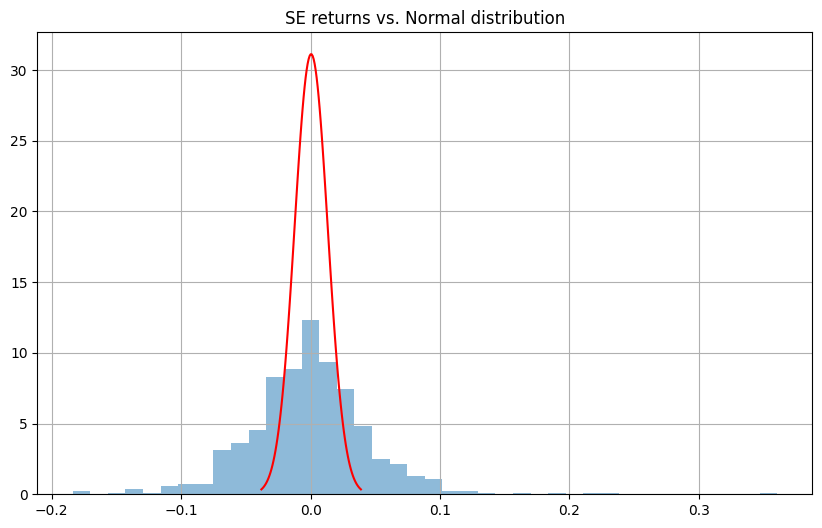

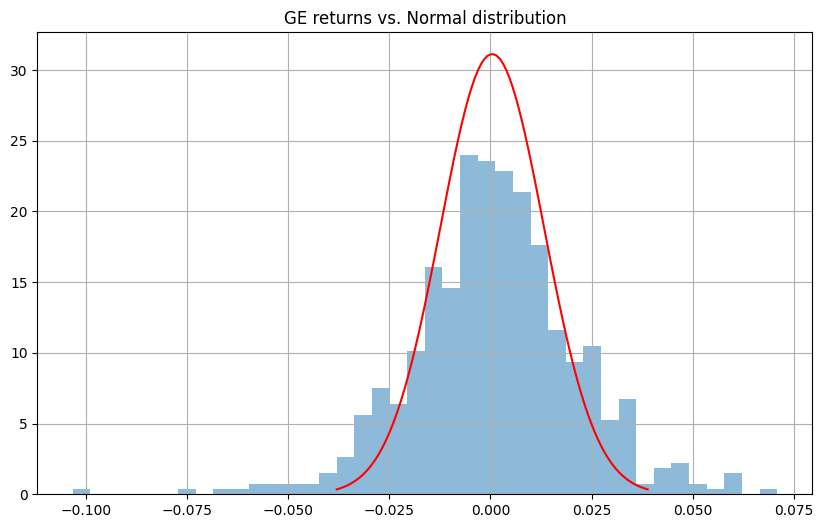

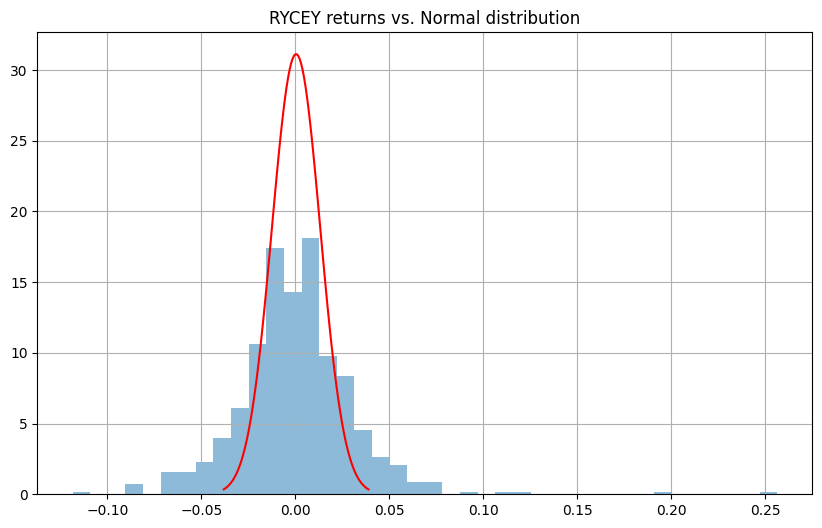

In [ ]:
for ticket in returns.columns:
    norm_ticket_dist(returns[1:], ticket)

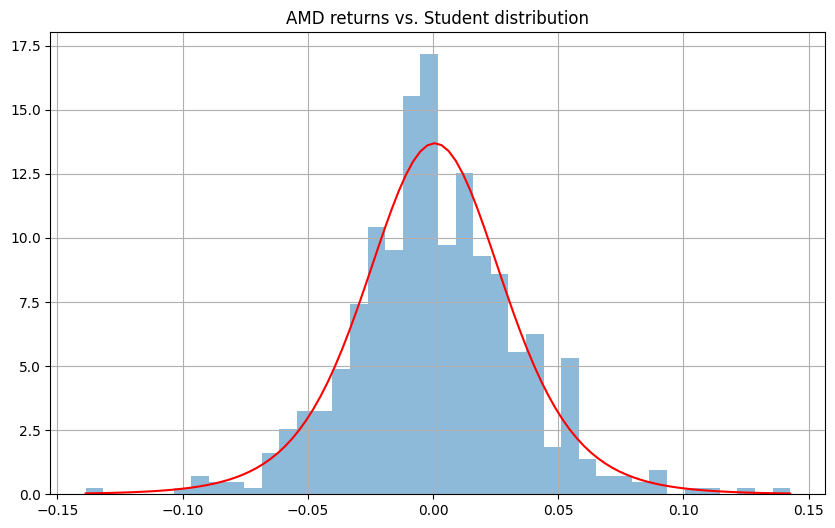

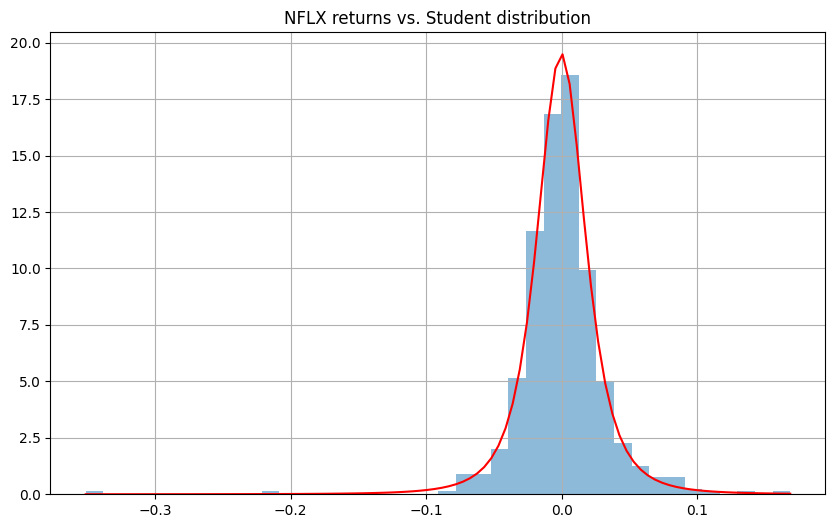

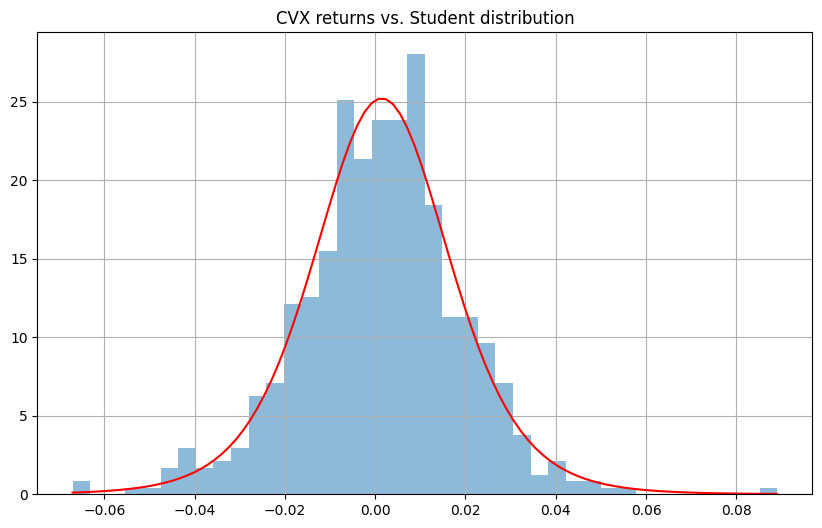

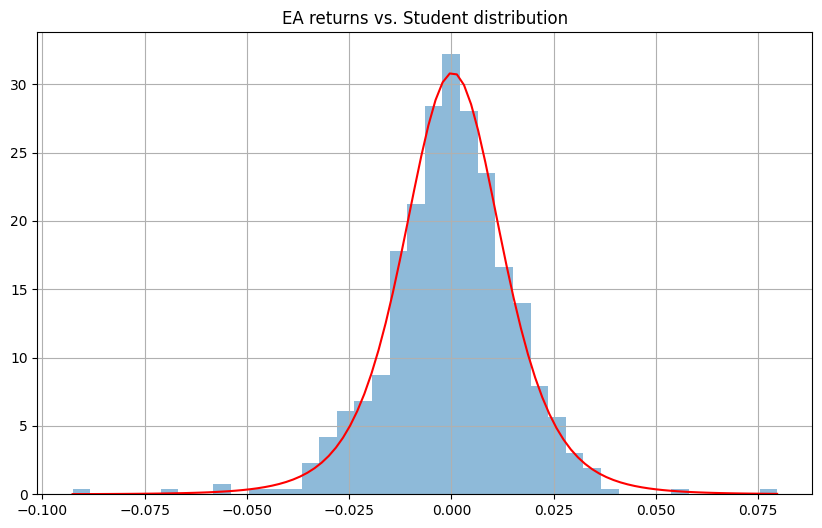

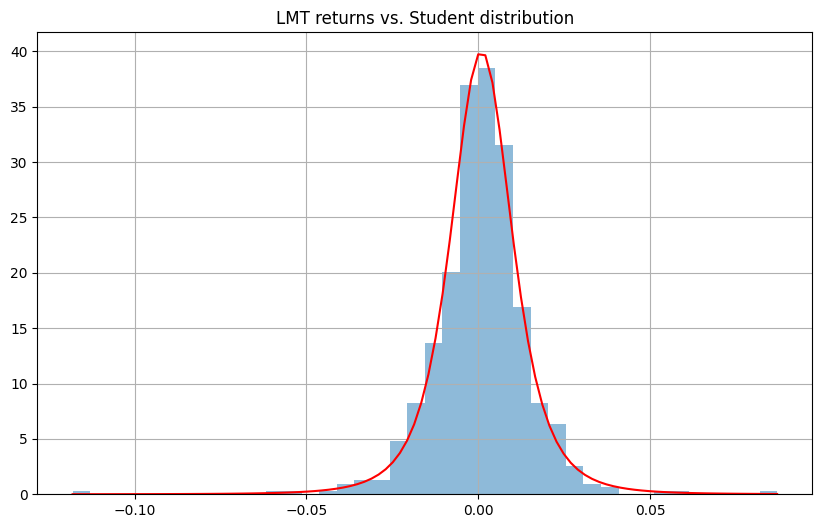

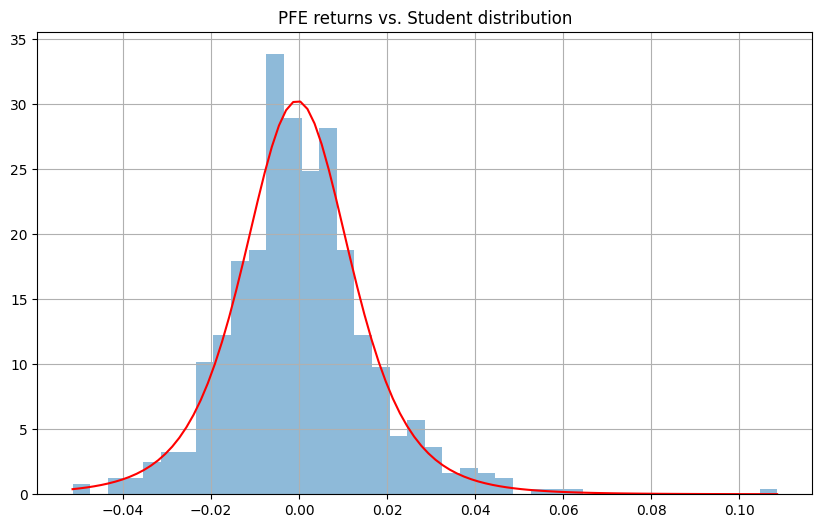

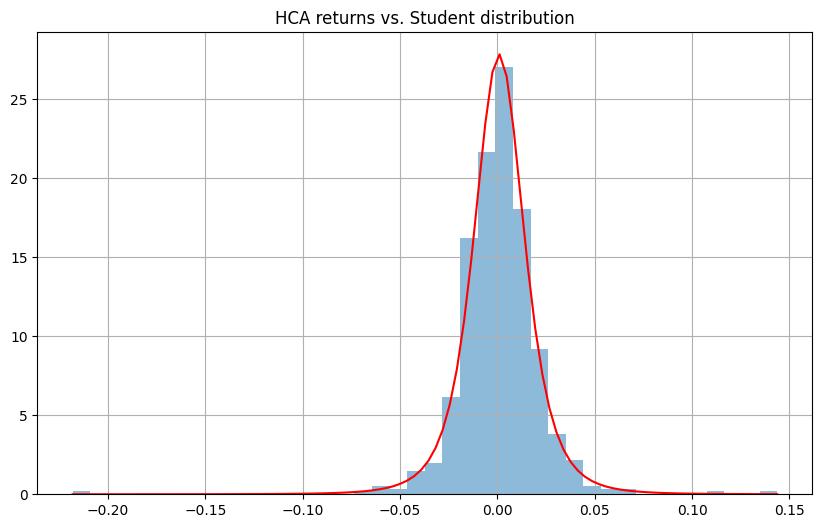

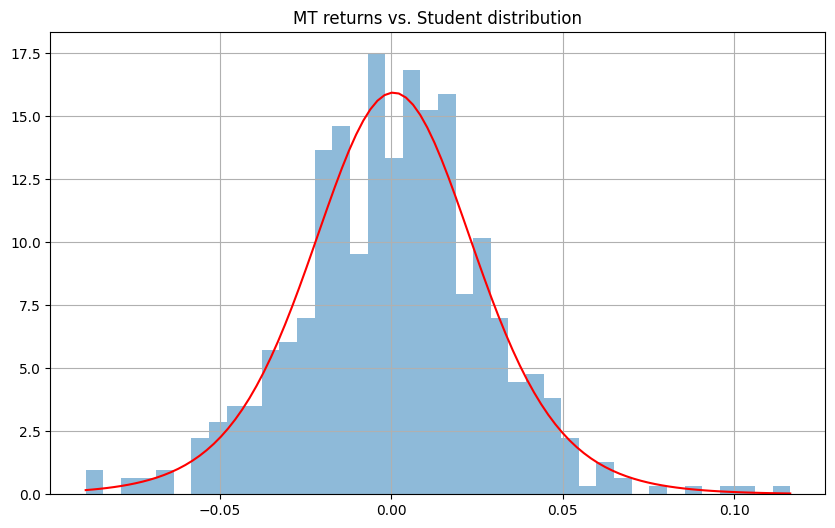

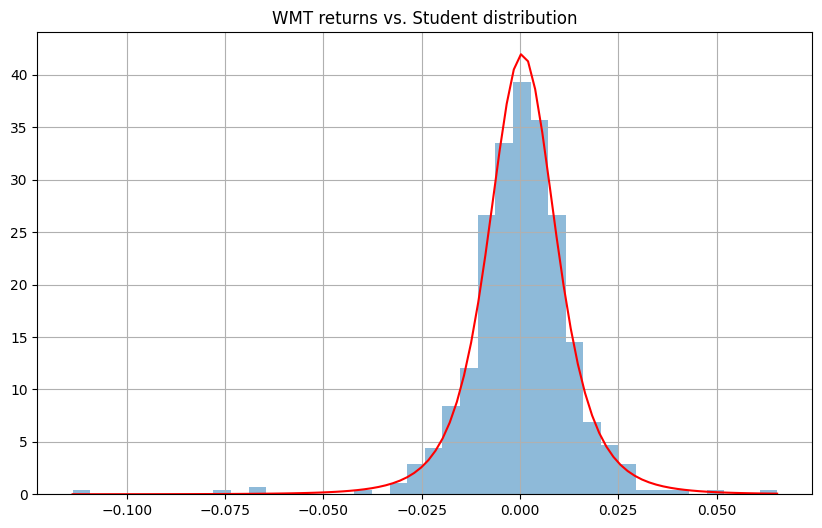

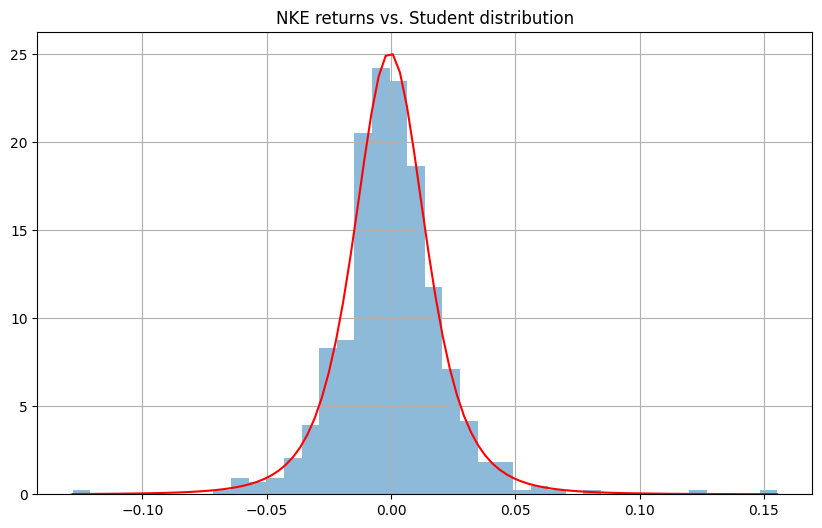

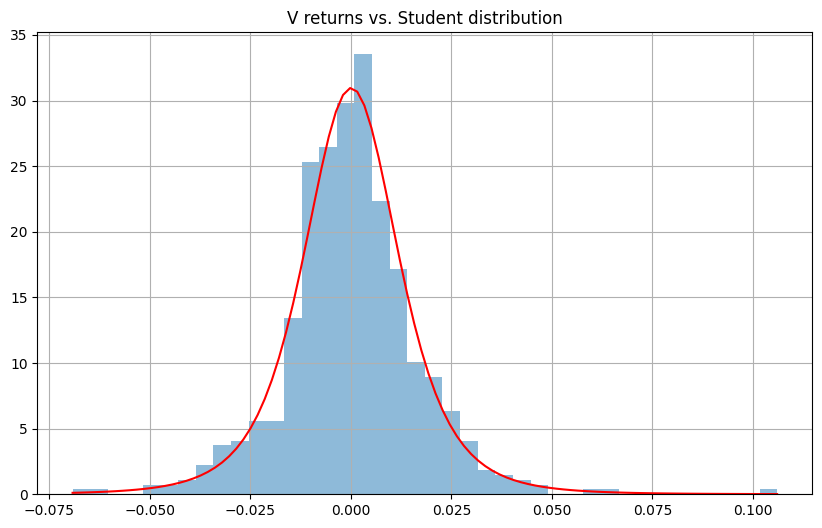

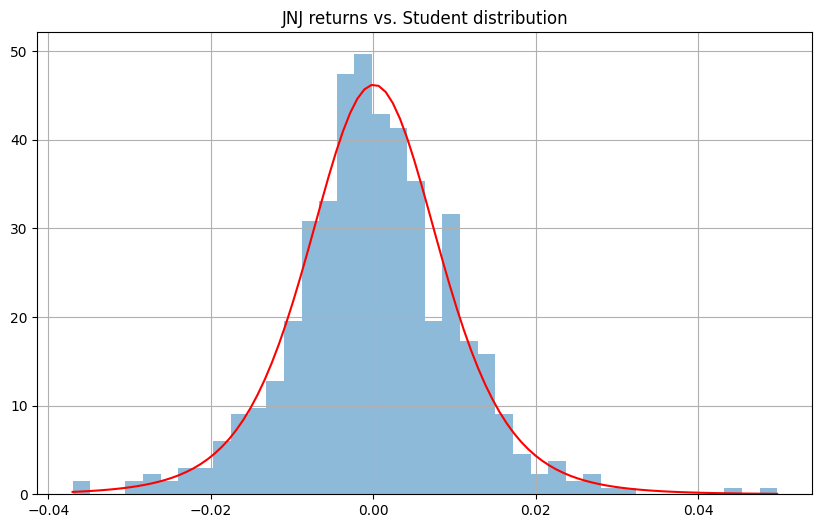

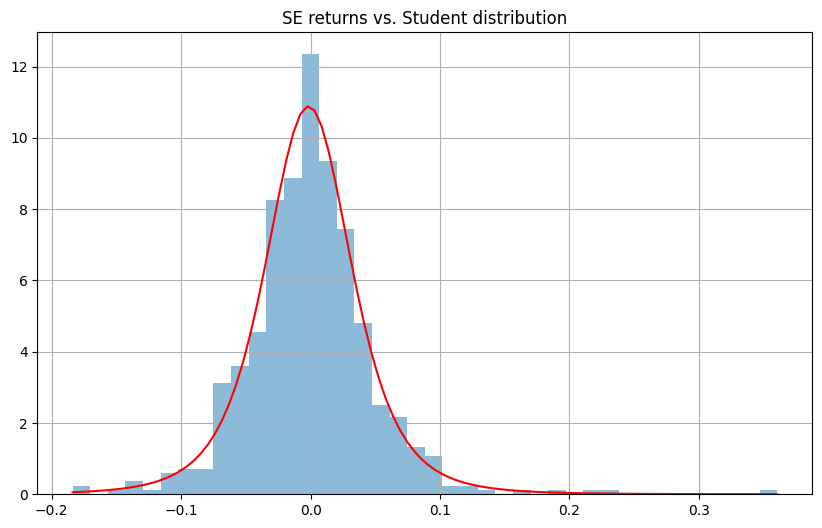

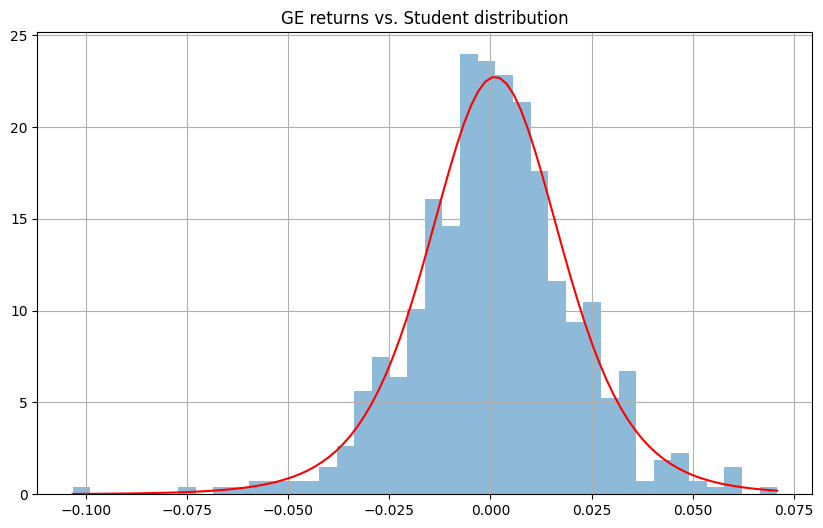

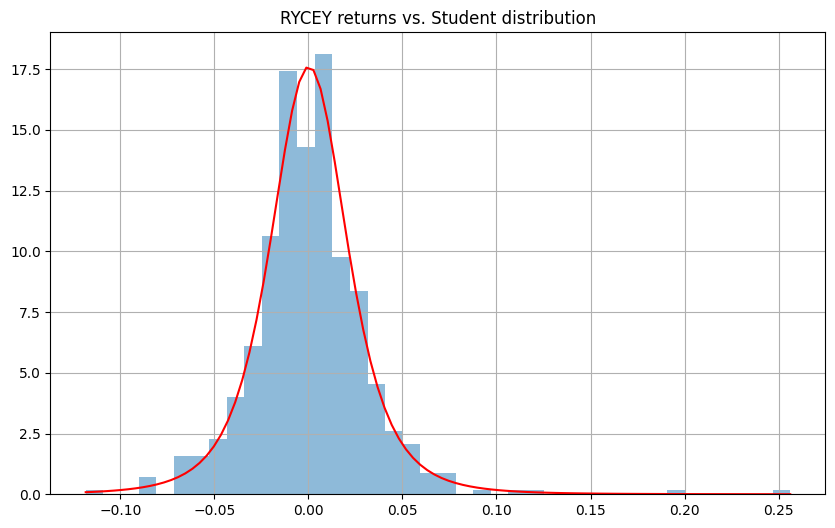

In [ ]:
for ticket in returns.columns:
    student_ticket_dist(returns[1:], ticket)

#VCV_Var

In [ ]:
def vcv(returns):

    cov_matrix = returns.cov()
    avg_rets = returns.mean()

    port_mean = avg_rets.dot(weights)
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

    mean_investment = (1+port_mean) * initial_investment
    stdev_investment = initial_investment * port_stdev

    cutoff = norm.ppf(conf_level, mean_investment, stdev_investment)

    vcv_var = initial_investment - cutoff
    vcv_var_prc = vcv_var/initial_investment
    return vcv_var_prc

In [ ]:
# Window
def breakdown_graph(returns, var_function, w = 200):
    i = w
    portf = returns.copy()
    var_values = pd.DataFrame({'Date': [], 'VaR': []})

    while i <=portf.shape[0]:
        var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i-1:i].index.date[0]], 'VaR': [-1*var_function(portf[i-w:i])]})])
        i+=1

    portf= portf[w:].dot(weights)
    var_values['Date'] = pd.to_datetime(var_values['Date'])
    var_df = var_values.merge(portf.reset_index(), on='Date')
    var_df.columns = ['Date', 'VaR', 'Change']
    var_df['Violation'] = (var_df['Change'] < var_df['VaR'])
    breakdowns = var_df[var_df['Violation'] == 1]


    fig, ax = plt.subplots(figsize=(10, 6))
    pos = portf[portf.apply(lambda x: x >= 0)]
    neg = portf[portf.apply(lambda x: x <  0)]

    plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
    plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
    plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'violations')
    plt.plot(var_df.Date, var_df.VaR, label = 'VaR', c = 'black')
    plt.legend()
    plt.title("{} VaR violations".format(var_function.__name__.upper()))
    plt.show();

    return var_df

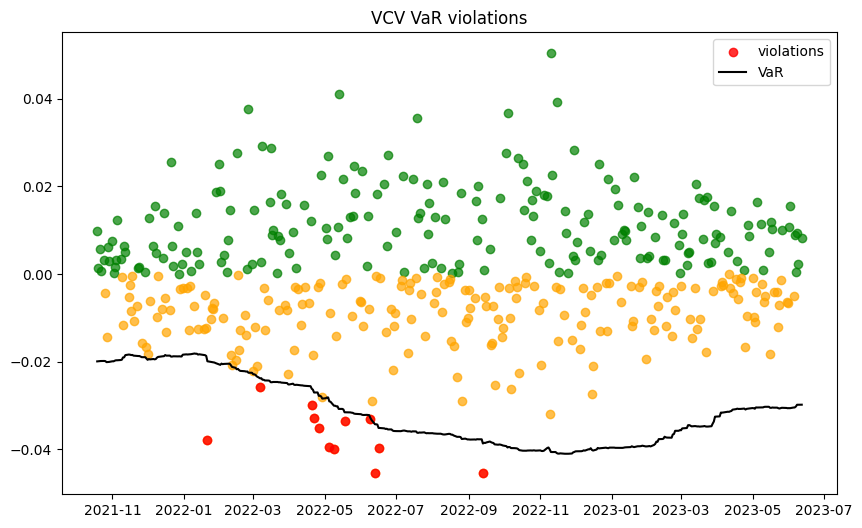

Число пробоев: 12


In [ ]:
vcv_df = breakdown_graph(returns, vcv, w = 200)
print('Число пробоев: {}'.format(vcv_df['Violation'].sum()))

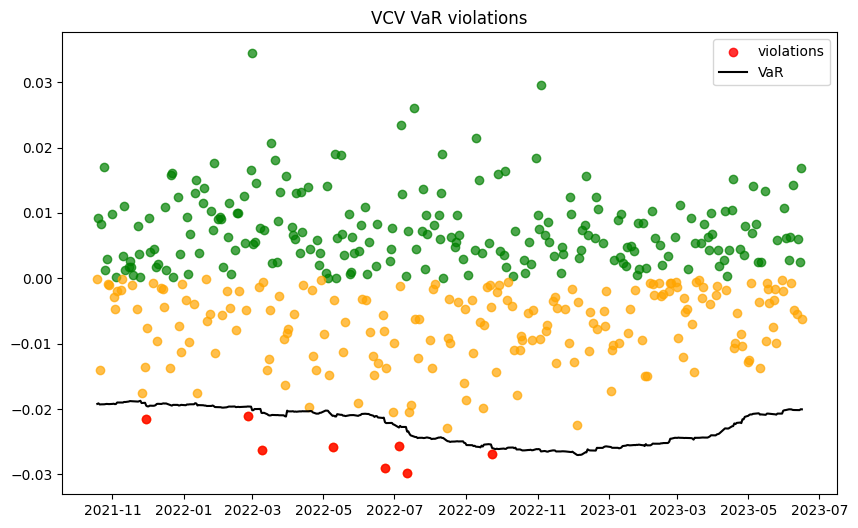

Число пробоев: 12


In [ ]:
vcv_df_com = breakdown_graph(com_returns, vcv, w = 200)
print('Число пробоев: {}'.format(vcv_df['Violation'].sum()))

## Backtesting

In [ ]:
tests(vcv_df)

0.00
0.40


In [ ]:
tests(vcv_df_com)

0.00
0.58


# Historical

In [ ]:
def hs(returns):
    hs_var = -initial_investment *np.quantile(returns.dot(weights)[1:], conf_level)
    hs_var_prc = hs_var/initial_investment
    return hs_var_prc

In [ ]:
# Window
def breakdown_graph(returns, var_function, w = 200):
    i = w
    portf = returns.copy()
    var_values = pd.DataFrame({'Date': [], 'VaR': []})

    while i <=portf.shape[0]:
        var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i-1:i].index.date[0]], 'VaR': [-1*var_function(portf[i-w:i])]})])
        i+=1

    portf= portf[w:].dot(weights)
    var_values['Date'] = pd.to_datetime(var_values['Date'])
    var_df = var_values.merge(portf.reset_index(), on='Date')
    var_df.columns = ['Date', 'VaR', 'Change']
    var_df['Violation'] = (var_df['Change'] < var_df['VaR'])
    breakdowns = var_df[var_df['Violation'] == 1]


    fig, ax = plt.subplots(figsize=(10, 6))
    pos = portf[portf.apply(lambda x: x >= 0)]
    neg = portf[portf.apply(lambda x: x <  0)]

    plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
    plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
    plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'violations')
    plt.plot(var_df.Date, var_df.VaR, label = 'VaR', c = 'black')
    plt.legend()
    plt.title("{} VaR violations".format(var_function.__name__.upper(), w))
    plt.show();

    return var_df

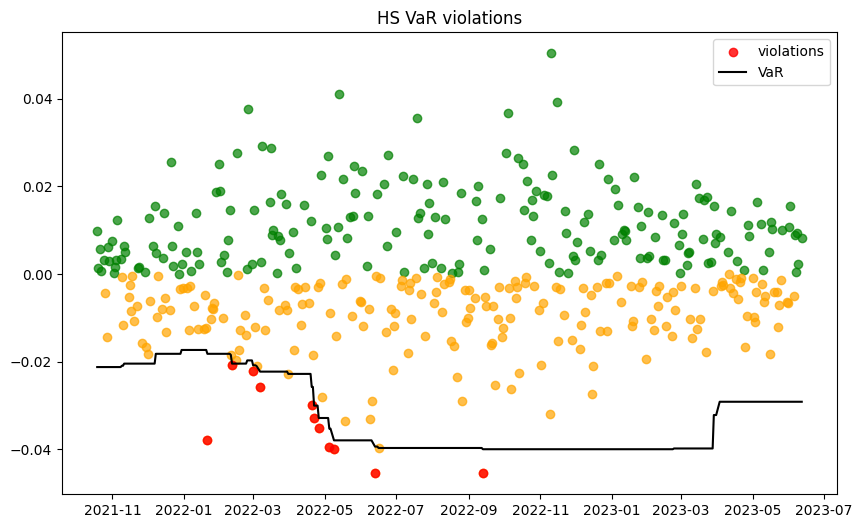

Число пробоев: 11


In [ ]:
hs_df = breakdown_graph(returns, hs, w = 200)
print('Число пробоев: {}'.format(hs_df['Violation'].sum()))

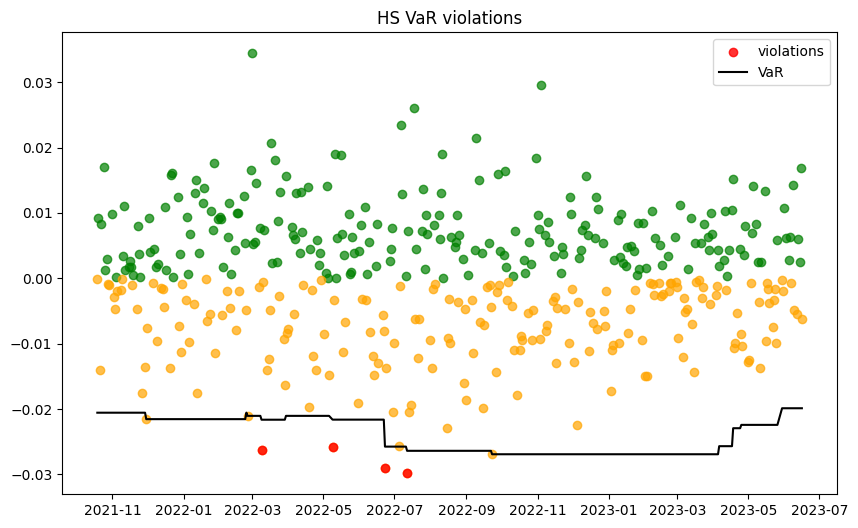

Число пробоев: 4


In [ ]:
hs_df_com = breakdown_graph(com_returns, hs, w = 200)
print('Число пробоев: {}'.format(hs_df_com['Violation'].sum()))

## Backtesting

In [ ]:
tests(hs_df)

0.00
0.44


In [ ]:
tests(hs_df_com)

0.01
0.78


# Monte Carlo

In [ ]:
def mcs(returns, n_simulations=10000):

    cov_matrix = returns.cov()
    avg_rets = returns.mean()

    port_mean = avg_rets.dot(weights)
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

    drift = port_mean - port_stdev**2/2
    simulations = np.random.normal(drift, port_stdev, n_simulations)
    mcs_var = -initial_investment *np.quantile(simulations, conf_level)
    mcs_var_prc = mcs_var/initial_investment
    return mcs_var_prc


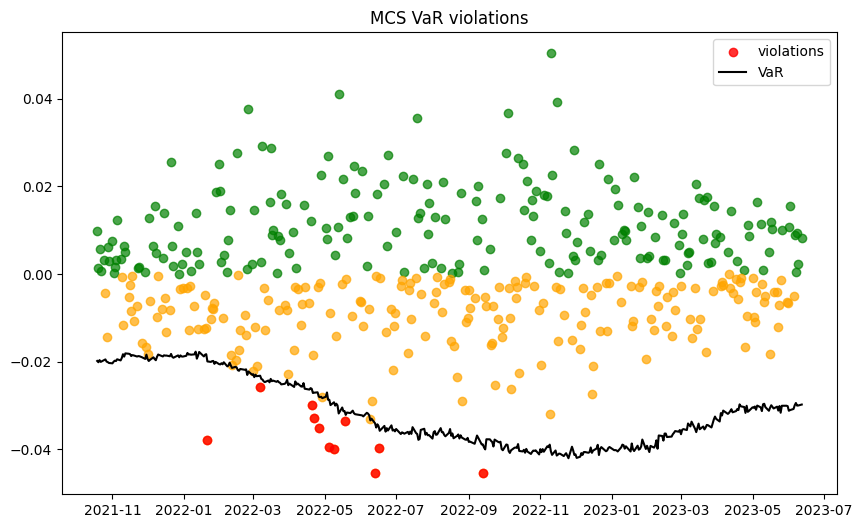

Число пробоев: 12


In [ ]:
mcs_df = breakdown_graph(returns, mcs, w = 200)
print('Число пробоев: {}'.format(vcv_df['Violation'].sum()))

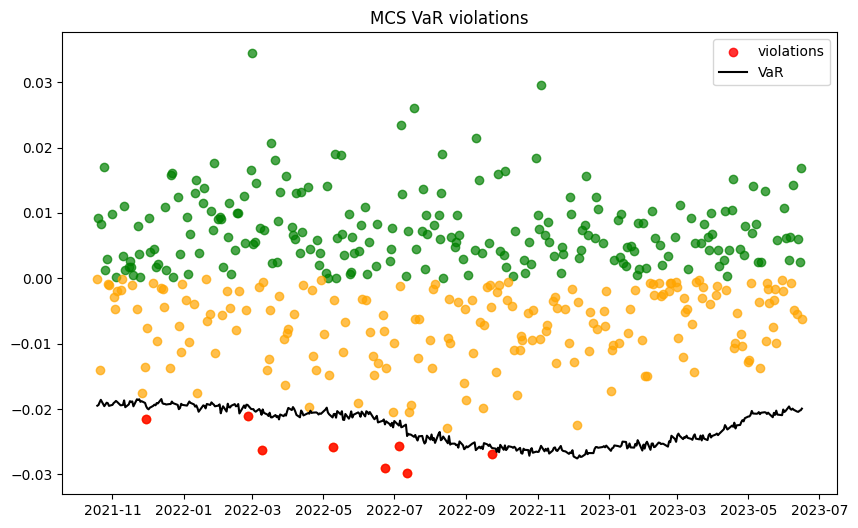

Число пробоев: 8


In [ ]:
mcs_df_com = breakdown_graph(com_returns, mcs, w = 200)
print('Число пробоев: {}'.format(mcs_df_com['Violation'].sum()))

## Backtesting

In [ ]:
tests(mcs_df)

0.00
0.44


In [ ]:
tests(mcs_df_com)

0.00
0.58
